In [1]:
import numpy as np
import pandas as pd
#import numpy and pandas libraries

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

import torch.nn as nn
import torch.nn.functional as F
from torch import optim

import matplotlib.pyplot as plt

#import necessary libraries in Pytorch and matplotlib

In [3]:
dataset_folder = "../../dataset/"
oil_df = pd.read_csv(dataset_folder + 'oil.csv')
coin_df = pd.read_csv(dataset_folder + 'coin.csv')
microsoft_df = pd.read_csv(dataset_folder + 'microsoft.csv')
sp500_df = pd.read_csv(dataset_folder + 'sp500.csv')
artificial1_df = pd.read_csv(dataset_folder + 'Artificial_trend.csv')

In [4]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
#we import MinMaxScaler function from sklearn to scale our dataset and also make a instance of that

In [5]:
def format_train_test (batch_size,data,percent,num_predicts):
    length_train = int(data.shape[0]*(1-percent))
    a1 = length_train//batch_size
    length_train = batch_size*a1
    train_data = data.iloc[:,1:2].values
    train_data = scaler.fit_transform(train_data)
    train_set = []
    train_label = []
    for i in range(length_train):
        train_set.append(train_data[i:i + num_predicts])
        train_label.append(train_data[i + num_predicts:i + 2*num_predicts])
    
    length_test = int(data.shape[0] - length_train - 4*num_predicts)
    a2 = length_test//batch_size
    length_test = int(batch_size*a2) 
    test = data.iloc[:,1:2].values
    test = scaler.fit_transform(test)
    test_data = test[length_train + 2*num_predicts:length_train + length_test + 4*num_predicts]
    test_set = []
    test_label = []
    for j in range(length_test):
        test_set.append(test_data[j:j + num_predicts])
        test_label.append(test_data[j + num_predicts:j + 2*num_predicts])
        
    
    train_set = np.reshape(np.array(train_set),(np.array(train_set).shape[0], np.array(train_set).shape[1], 1))
    train_label = np.reshape(np.array(train_label),(np.array(train_label).shape[0], np.array(train_label).shape[1]))
    test_set = np.reshape(np.array(test_set),(np.array(test_set).shape[0], np.array(test_set).shape[1], 1))
    test_label = np.reshape(np.array(test_label),(np.array(test_label).shape[0], np.array(test_label).shape[1]))
    
    return train_set, train_label, test_set, test_label, length_test
#Here is the function to make train set, test set, and label for each of them from the dataframe. We first want to see how many
#We want to find the percent of data used for train set. Then, we find length of train data so that it could divisible by batch 
#size. Then we scale the dataset and make train set and label for each by iterating through the dataset until and make them lag
#by number of predict steps we want until we have desired amount of data for train process. Then, we find the length for test
#set and we repeat the same process as forming train set and its label.

In [22]:
train_set, train_label, test_set, test_label, length_test = format_train_test(64,coin_df,0.2,5)

train_set, train_label, test_set, test_label = map(torch.tensor,(train_set, train_label, test_set, test_label))

train = TensorDataset(train_set, train_label)
train_tensor = DataLoader(train, batch_size = 64, shuffle=True)

test = TensorDataset(test_set, test_label)
test_tensor = DataLoader(test, batch_size= 64, shuffle=False)

#we then make train, test sets, and their labels. Then we convert them to torch tensors and make torch dataset and use DataLoader to 
#to make data ready for training and testing. Here batch size is 64, percent of test set is 0.2 and 5 predictions steps

In [23]:
class LSTM_model(nn.Module):
    def __init__(self, out_size, in_size, hidden_size1, hidden_size2,batch_size):
        super().__init__()
        self.batch_size = batch_size
        self.in_size = in_size
        self.out_size = out_size
        self.hidden_size1 = hidden_size1
        self.hidden_size2 = hidden_size2
        self.lstm1 = nn.LSTM(input_size=self.in_size,hidden_size=self.hidden_size1,num_layers=2,batch_first=True)
        self.lstm2 = nn.LSTM(input_size=self.hidden_size1,hidden_size=self.hidden_size2,num_layers=2,batch_first=True)
        self.last = nn.Linear(self.hidden_size2, self.out_size)
    def forward(self,x,old_state):
        s1,state1 = self.lstm1(x,old_state)
        s2,state2 = self.lstm2(s1,state1)
        return self.last(s2[:,-1]), state2
    def initial_s(self, num_predicts):
        return (torch.zeros(2,self.batch_size, self.hidden_size1),
                torch.zeros(2,self.batch_size, self.hidden_size1))
#Here we make a class of LSTM models. We use two lstm steps with 2 layers each and then the dense layer at the end to output prediction
#Here we also need to keep track of the state for LSTM layers. We also make initial states with 2 zeros tensors

In [24]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
device
# we check for the availablibility of GPU to use for training

device(type='cuda', index=0)

In [25]:
model = LSTM_model(5,1,5,5,64)
model = model.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
#we make model, upload it to GPU, make CrossEntropy loss instance as long as the Adam optimizer with learning rate of 0.001

In [26]:
print(model) #print the model summary

LSTM_model(
  (lstm1): LSTM(1, 5, num_layers=2, batch_first=True)
  (lstm2): LSTM(5, 5, num_layers=2, batch_first=True)
  (last): Linear(in_features=5, out_features=5, bias=True)
)


In [27]:
def train_test(model,train_tensor,test_tensor,criterion,optimizer,device,num_predicts,iterations):
    tr = []
    te = []
    predict = []
    for layer in model.children():
        layer.reset_parameters()
    for i in range(iterations):
        h0, c0 = model.initial_s(num_predicts)
        h, c = h0.to(device), c0.to(device)
        for (x,y) in train_tensor:
            x, y = x.to(device), y.to(device)
            y_hat, (h, c) = model(x.float(), (h, c))
            loss = criterion(y_hat, y.float())
            optimizer.zero_grad()
            h = h.detach()
            c = c.detach()
            loss.backward()
            optimizer.step()
        with torch.no_grad():
            h01, c01 = model.initial_s(num_predicts)
            h1, c1 = h01.to(device), c01.to(device)
            lost_val = 0
            for (x1, y1) in test_tensor:
                x1, y1 = x1.to(device), y1.to(device)
                y_hat1, (h1, c1) = model(x1.float(),(h1,c1))
                loss1 = criterion(y_hat1, y1.float())
                lost_val += loss1.item()
                h1 = h1.detach()
                c1 = c1.detach()
                if i == (iterations-1):
                    predict.append(y_hat1)
                
            lost_val /= len(x1)
            tr.append(loss.item())
            te.append(lost_val)
            print(f"Iteration {i}\n********************")
            print('The loss for train is: ',loss.item())
            print('The loss for test is: ',lost_val)
            for j in range(len(predict)):
                predict[j] = predict[j].cpu().numpy()
    return i, tr, te, predict
#Here we create function to do the training and validation process. We iterate through number of epochs, make initial state for model
#and iterate through each data batch to do prediction, compute the loss and do backward propagation to improve the parameters. In
#the same epoch, I also apply the model to make prediction on test dataset to keep track of model performace more closely. I also
#print iteration round, train loss, and test loss. I also return them to do some plots later.

In [28]:
import os
os.environ["CUBLAS_WORKSPACE_CONFIG"]=":16:8"

In [29]:
iterations, tr, te, predict = train_test(model,train_tensor,test_tensor,criterion,optimizer,device,5,100)

Iteration 0
********************
The loss for train is:  0.3260708451271057
The loss for test is:  0.1392835108563304
Iteration 1
********************
The loss for train is:  0.2674897313117981
The loss for test is:  0.12262669205665588
Iteration 2
********************
The loss for train is:  0.1623862385749817
The loss for test is:  0.09589972626417875
Iteration 3
********************
The loss for train is:  0.07553360611200333
The loss for test is:  0.05186711298301816
Iteration 4
********************
The loss for train is:  0.05249372124671936
The loss for test is:  0.03299305750988424
Iteration 5
********************
The loss for train is:  0.05216381698846817
The loss for test is:  0.0349562200717628
Iteration 6
********************
The loss for train is:  0.04254920780658722
The loss for test is:  0.033847557846456766
Iteration 7
********************
The loss for train is:  0.02008882164955139
The loss for test is:  0.019568385207094252
Iteration 8
********************
The loss f

In [30]:
def plot_tr_te(iterations,tr,te,title):
    t = np.arange(0,iterations+1)
    y1 = np.array(tr)
    y2 = np.array(te)
    plt.figure(figsize=(6, 4))
    plt.title('Plot of train and test loss vs iterations for '+title)
    plt.plot(t, y1)
    plt.plot(t, y2)
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.legend(["train", "test"])

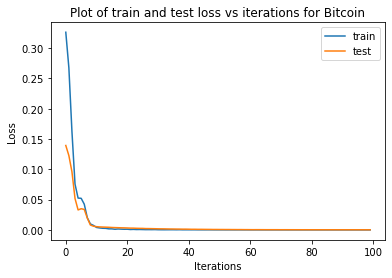

In [31]:
plot_tr_te(iterations,tr,te,'Bitcoin')

In [19]:
train_set, train_label, test_set, test_label, length_test = format_train_test(64,oil_df,0.2,5)

train_set, train_label, test_set, test_label = map(torch.tensor,(train_set, train_label, test_set, test_label))

train = TensorDataset(train_set, train_label)
train_tensor = DataLoader(train, batch_size = 64, shuffle=True)

test = TensorDataset(test_set, test_label)
test_tensor = DataLoader(test, batch_size= 64, shuffle=False)

In [20]:
iterations, tr, te, predict = train_test(model,train_tensor,test_tensor,criterion,optimizer,device,5,100)

C:\Users\minhk\anaconda3\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([64, 5, 1])) that is different to the input size (torch.Size([64, 5, 5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Iteration 0
********************
The loss for train is:  0.20950423181056976
The loss for test is:  0.02810027520172298
Iteration 1
********************
The loss for train is:  0.11797574907541275
The loss for test is:  0.01835267653223127
Iteration 2
********************
The loss for train is:  0.02847488597035408
The loss for test is:  0.005901406169869006
Iteration 3
********************
The loss for train is:  0.052306175231933594
The loss for test is:  0.0015912429880700074
Iteration 4
********************
The loss for train is:  0.05154603719711304
The loss for test is:  0.0015548209266853519
Iteration 5
********************
The loss for train is:  0.04046229273080826
The loss for test is:  0.001637987035792321
Iteration 6
********************
The loss for train is:  0.03942566737532616
The loss for test is:  0.001642696290218737
Iteration 7
********************
The loss for train is:  0.04020800441503525
The loss for test is:  0.0016278077673632652
Iteration 8
******************

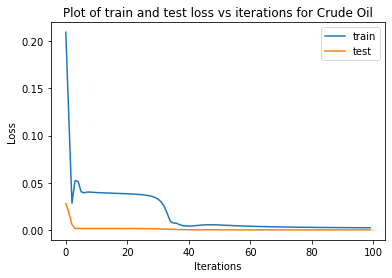

In [21]:
plot_tr_te(iterations,tr,te,'Crude Oil')

In [22]:
train_set, train_label, test_set, test_label,length_test = format_train_test(64,artificial1_df,0.2,5)

train_set, train_label, test_set, test_label = map(torch.tensor,(train_set, train_label, test_set, test_label))

train = TensorDataset(train_set, train_label)
train_tensor = DataLoader(train, batch_size = 64, shuffle=True)

test = TensorDataset(test_set, test_label)
test_tensor = DataLoader(test, batch_size= 64, shuffle=False)

In [23]:
iterations, tr, te, predict = train_test(model,train_tensor,test_tensor,criterion,optimizer,device,5,100)

C:\Users\minhk\anaconda3\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([64, 5, 1])) that is different to the input size (torch.Size([64, 5, 5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Iteration 0
********************
The loss for train is:  0.008404660038650036
The loss for test is:  0.01344949152553454
Iteration 1
********************
The loss for train is:  0.0019362656166777015
The loss for test is:  0.014242278537494713
Iteration 2
********************
The loss for train is:  0.0014477602671831846
The loss for test is:  0.014288719139585737
Iteration 3
********************
The loss for train is:  0.0011940243421122432
The loss for test is:  0.013939904691142146
Iteration 4
********************
The loss for train is:  0.001148840063251555
The loss for test is:  0.012145409922595718
Iteration 5
********************
The loss for train is:  0.003821526886895299
The loss for test is:  0.007092825402651215
Iteration 6
********************
The loss for train is:  0.001538740238174796
The loss for test is:  0.004888549343377235
Iteration 7
********************
The loss for train is:  0.0008025075076147914
The loss for test is:  0.0034468093826944823
Iteration 8
********

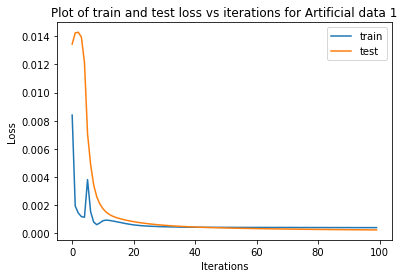

In [24]:
plot_tr_te(iterations,tr,te,'Artificial data 1')

In [25]:
train_set, train_label, test_set, test_label,length_test = format_train_test(64,microsoft_df,0.2,5)

train_set, train_label, test_set, test_label = map(torch.tensor,(train_set, train_label, test_set, test_label))

train = TensorDataset(train_set, train_label)
train_tensor = DataLoader(train, batch_size = 64, shuffle=True)

test = TensorDataset(test_set, test_label)
test_tensor = DataLoader(test, batch_size= 64, shuffle=False)

In [26]:
iterations, tr, te, predict = train_test(model,train_tensor,test_tensor,criterion,optimizer,device,5,100)

C:\Users\minhk\anaconda3\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([64, 5, 1])) that is different to the input size (torch.Size([64, 5, 5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Iteration 0
********************
The loss for train is:  0.20245623588562012
The loss for test is:  0.039722015149891376
Iteration 1
********************
The loss for train is:  0.09143360704183578
The loss for test is:  0.0257184321526438
Iteration 2
********************
The loss for train is:  0.07906685024499893
The loss for test is:  0.02454946981742978
Iteration 3
********************
The loss for train is:  0.08019240200519562
The loss for test is:  0.024815251817926764
Iteration 4
********************
The loss for train is:  0.07971224933862686
The loss for test is:  0.024791864212602377
Iteration 5
********************
The loss for train is:  0.07958702743053436
The loss for test is:  0.02480359375476837
Iteration 6
********************
The loss for train is:  0.07937771081924438
The loss for test is:  0.024780298583209515
Iteration 7
********************
The loss for train is:  0.07894132286310196
The loss for test is:  0.024718347005546093
Iteration 8
********************
The

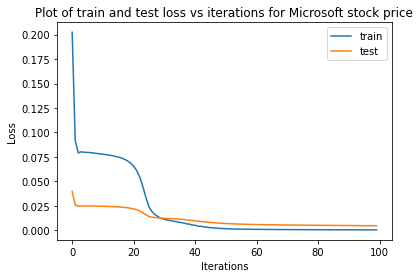

In [27]:
plot_tr_te(iterations,tr,te,'Microsoft stock price')

In [28]:
train_set, train_label, test_set, test_label, length_test = format_train_test(64,sp500_df,0.2,5)

train_set, train_label, test_set, test_label = map(torch.tensor,(train_set, train_label, test_set, test_label))

train = TensorDataset(train_set, train_label)
train_tensor = DataLoader(train, batch_size = 64, shuffle=True)

test = TensorDataset(test_set, test_label)
test_tensor = DataLoader(test, batch_size= 64, shuffle=False)

In [29]:
iterations, tr, te, predict = train_test(model,train_tensor,test_tensor,criterion,optimizer,device,5,100)

C:\Users\minhk\anaconda3\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([64, 5, 1])) that is different to the input size (torch.Size([64, 5, 5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Iteration 0
********************
The loss for train is:  0.07033682614564896
The loss for test is:  0.022938275593332946
Iteration 1
********************
The loss for train is:  0.0258766021579504
The loss for test is:  0.01622809562832117
Iteration 2
********************
The loss for train is:  0.01059809047728777
The loss for test is:  0.013884129759389907
Iteration 3
********************
The loss for train is:  0.0062428927049040794
The loss for test is:  0.01328630864736624
Iteration 4
********************
The loss for train is:  0.005281324498355389
The loss for test is:  0.013206692296080291
Iteration 5
********************
The loss for train is:  0.005162924528121948
The loss for test is:  0.013238417886896059
Iteration 6
********************
The loss for train is:  0.005136275198310614
The loss for test is:  0.01325326698133722
Iteration 7
********************
The loss for train is:  0.0051041352562606335
The loss for test is:  0.013253544078906998
Iteration 8
*****************

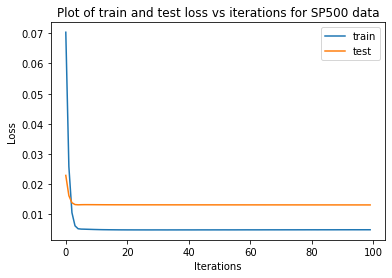

In [30]:
plot_tr_te(iterations,tr,te,'SP500 data')

In [32]:
def plot_test(test_label,predict,test_length,num_predicts):
    a = np.asarray(predict)
    a = np.reshape(a,(-1,1))
    #a = scaler.inverse_transform(a)
    b = np.asarray(test_label)
    #b = scaler.inverse_transform(b)
    b = np.reshape(b,(-1,1))
    #temp = []
    
    print(a.shape)
    print(b.shape)
    #for i in range(0,test_length):
        #temp.append(a[i,num_predicts-5])
    #temp = np.array(temp)
    #temp = np.reshape(temp,(temp.shape[0],1))
    #print(temp.shape)
    plt.plot(a)
    plt.plot(b)

(2880, 1)
(2880, 1)


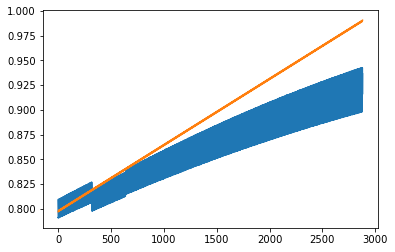

In [33]:
plot_test(test_label,predict,length_test,5)

In [ ]:
criterion1 = nn.MSELoss()
criterion2 = nn.L1Loss()
criterion3 = nn.NLLLoss()

In [ ]:
#we need to try with three other loss functions as well